# Exploring the WWI Data Warehouse

## Configure Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from matplotlib.dates import datestr2num, num2date


pd.set_option('display.max_columns', None)
sns.set_theme(context='talk', style='darkgrid', palette='deep')

## Creating a Joint Dataframe

### Reading in the Fact and Dimension Tables

In [2]:
fact_table = pd.read_csv("data/preprocessed/fact.sale.csv")
date_dimension = pd.read_csv("data/preprocessed/dim.date.csv")
product_dimension = pd.read_csv("data/preprocessed/dim.stockItem.csv")
customer_dimension = pd.read_csv("data/preprocessed/dim.customer.csv")
city_dimension = pd.read_csv("data/preprocessed/dim.city.csv")
employee_dimension = pd.read_csv("data/preprocessed/dim.employee.csv")
payment_dimension = pd.read_csv("data/preprocessed/dim.payment.csv")

### Create New Columns and Merge Tables

In [3]:
# Create column in the fact table calculating profit in millions.
fact_table["Profit (Millions)"] = fact_table["Profit"] / 1e6

# Create column in the fact table calculating profit in thousands.
fact_table["Profit (Thousands)"] = fact_table["Profit"] / 1e3

# Merge the fact and dimension tables on primary keys using an inner join.
df = fact_table.merge(
    date_dimension, left_on="Invoice Date Key", right_on="Date", suffixes=('', '_y')
).merge(
    product_dimension, on="Stock Item Key", suffixes=('', '_y')
).merge(
    customer_dimension, on="Customer Key", suffixes=('', '_y')
).merge(
    city_dimension, on="City Key", suffixes=('', '_y')
).merge(
    employee_dimension, left_on="Salesperson Key", right_on="Employee Key", suffixes=('', '_y')
)

# Drop duplicate columns.
df.drop(df.filter(regex='_y$').columns, axis=1, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])

# Display table information.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228265 entries, 0 to 228264
Data columns (total 75 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Sale Key                    228265 non-null  int64         
 1   City Key                    228265 non-null  int64         
 2   Customer Key                228265 non-null  int64         
 3   Bill To Customer Key        228265 non-null  int64         
 4   Stock Item Key              228265 non-null  int64         
 5   Invoice Date Key            228265 non-null  object        
 6   Delivery Date Key           227981 non-null  object        
 7   Salesperson Key             228265 non-null  int64         
 8   WWI Invoice ID              228265 non-null  int64         
 9   Description                 228265 non-null  object        
 10  Package                     228265 non-null  object        
 11  Quantity                    228265 non-

## Exploring How Profits Have Evolved Over Time

In [15]:
# Calculate total profits by each month in the fiscal year.
profits_by_fiscal_month = df.groupby(
    ["Fiscal Year", "Month", "Fiscal Month Number"]
    )[
        ["Profit", "Profit (Millions)"]
    ].sum().reset_index().sort_values(["Fiscal Month Number"])

# Calculate total profits in each fiscal year.
profits_by_fiscal_year = df.groupby(
    "Fiscal Year"
    )[
        ["Profit", "Profit (Millions)"]
    ].sum().reset_index().sort_values(["Fiscal Year"])

### Total Profit (in Millions) Generated Each Fiscal Year

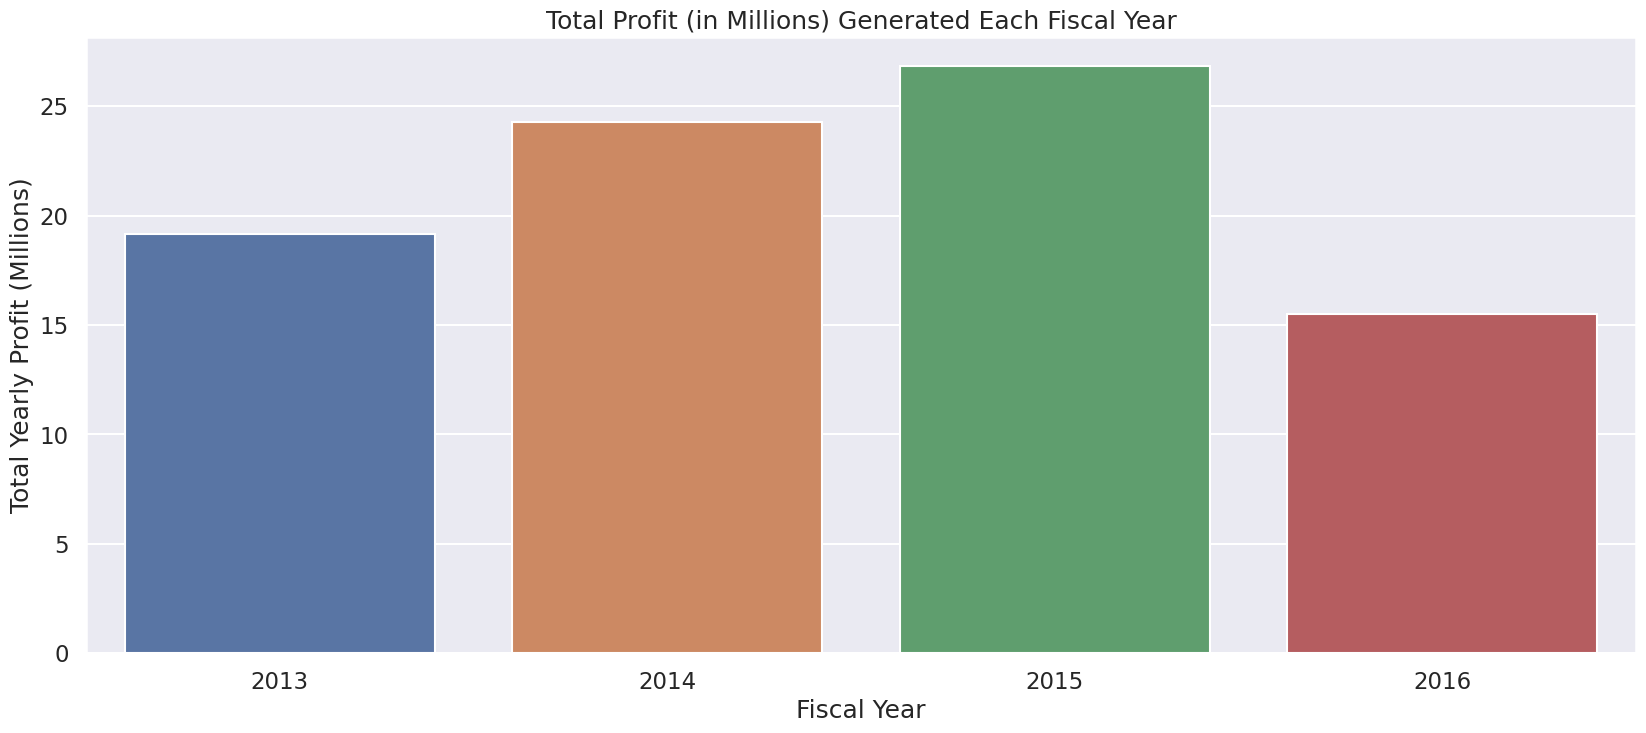

In [5]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    x="Fiscal Year",
    y="Profit (Millions)",
    data=profits_by_fiscal_year,
    ax=ax,
)

plt.ylabel("Total Yearly Profit (Millions)")
plt.title("Total Profit (in Millions) Generated Each Fiscal Year");

### Total Monthly Profit (in Millions) By Fiscal Year

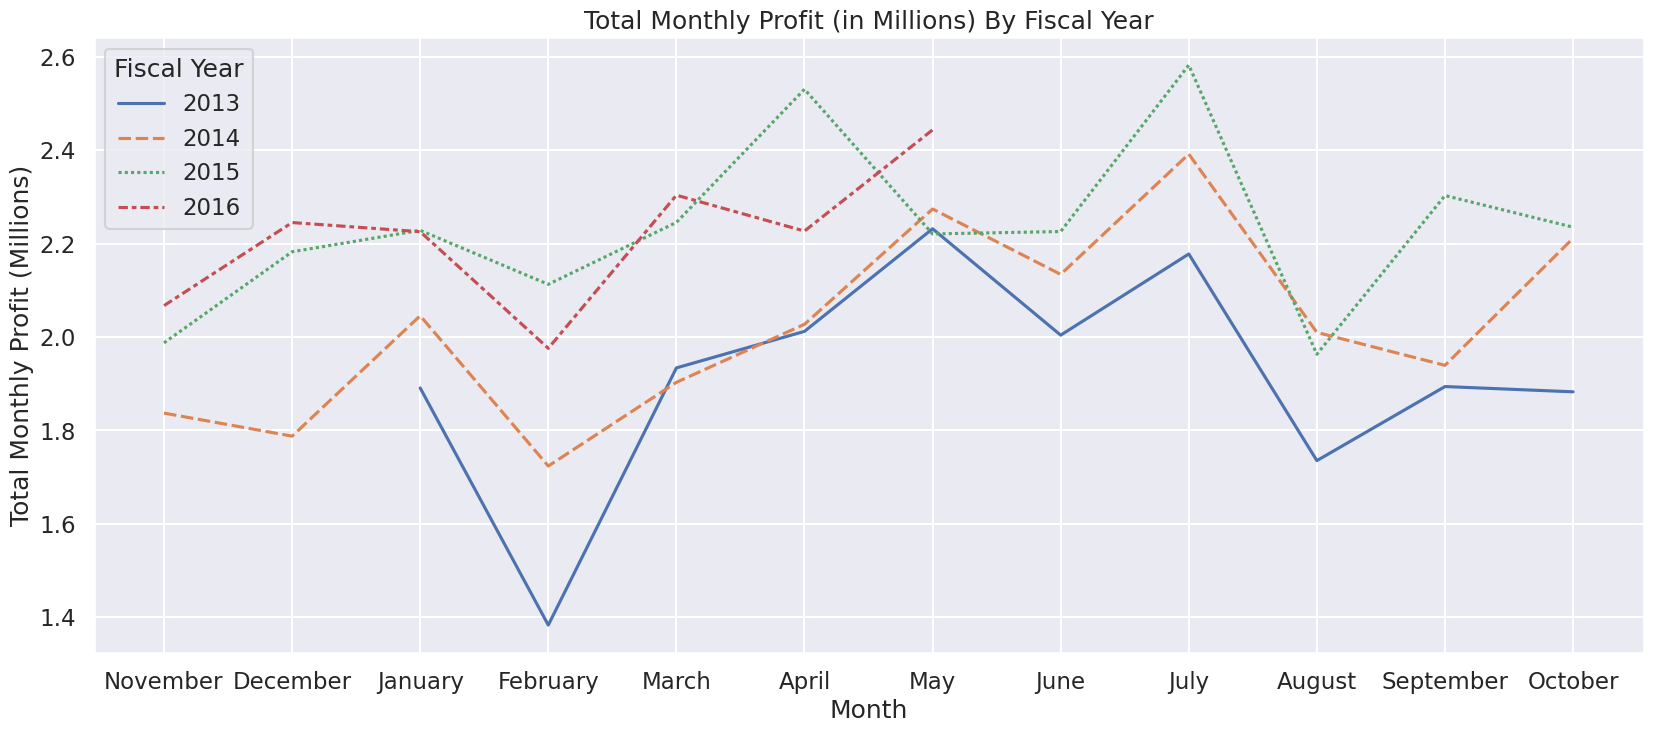

In [6]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.lineplot(
    x="Month",
    y="Profit (Millions)",
    data=profits_by_fiscal_month,
    hue="Fiscal Year",
    style="Fiscal Year",
    palette="deep",
    ax=ax,
)
plt.ylabel("Total Monthly Profit (Millions)")
plt.title("Total Monthly Profit (in Millions) By Fiscal Year");

### Average Monthly Profit (in Millions) By Fiscal Year

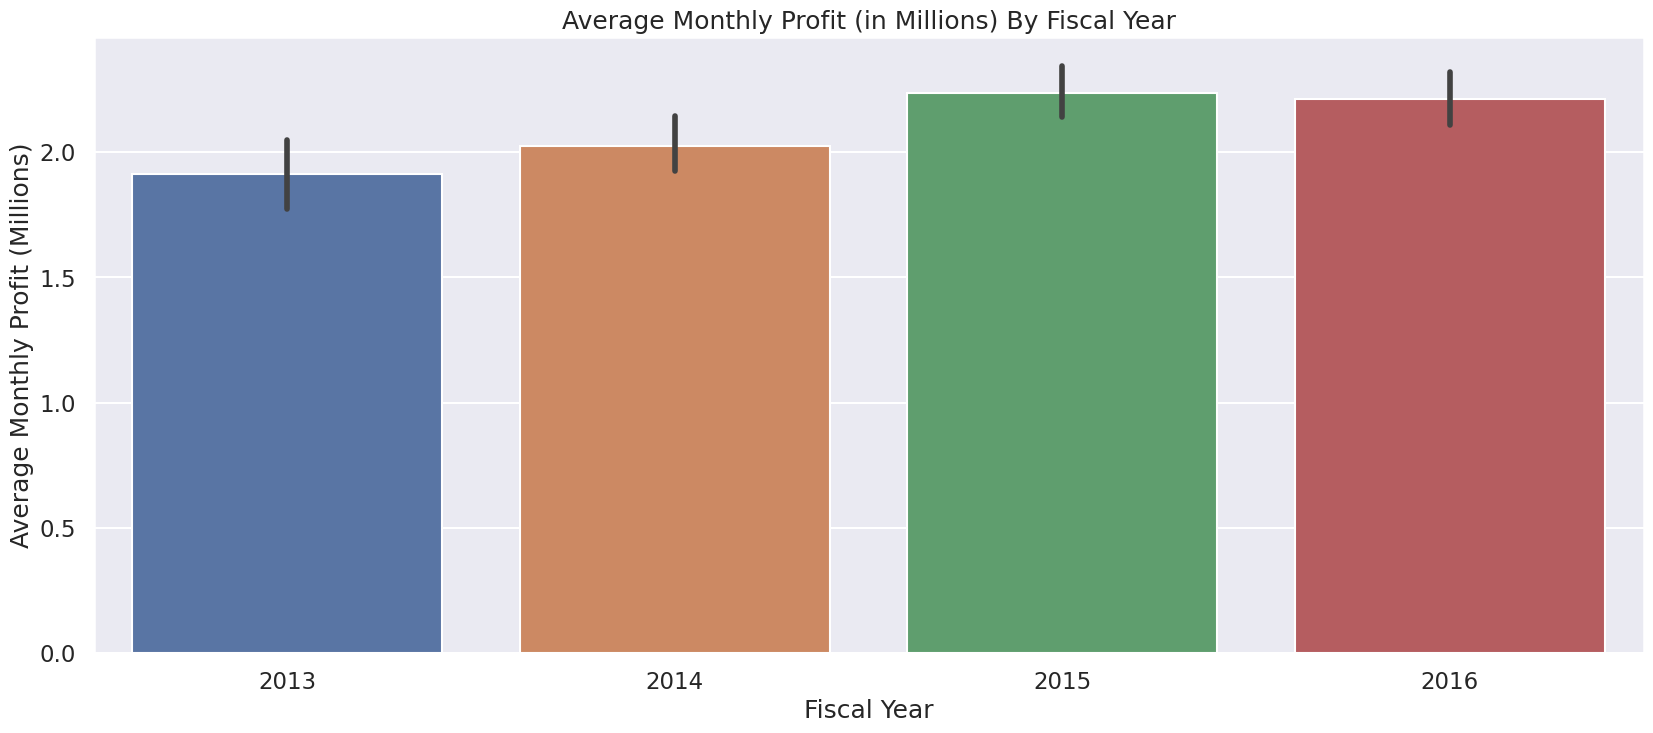

In [7]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    x="Fiscal Year",
    y="Profit (Millions)",
    data=profits_by_fiscal_month,
    ax=ax,
)

plt.ylabel("Average Monthly Profit (Millions)")
plt.title("Average Monthly Profit (in Millions) By Fiscal Year");

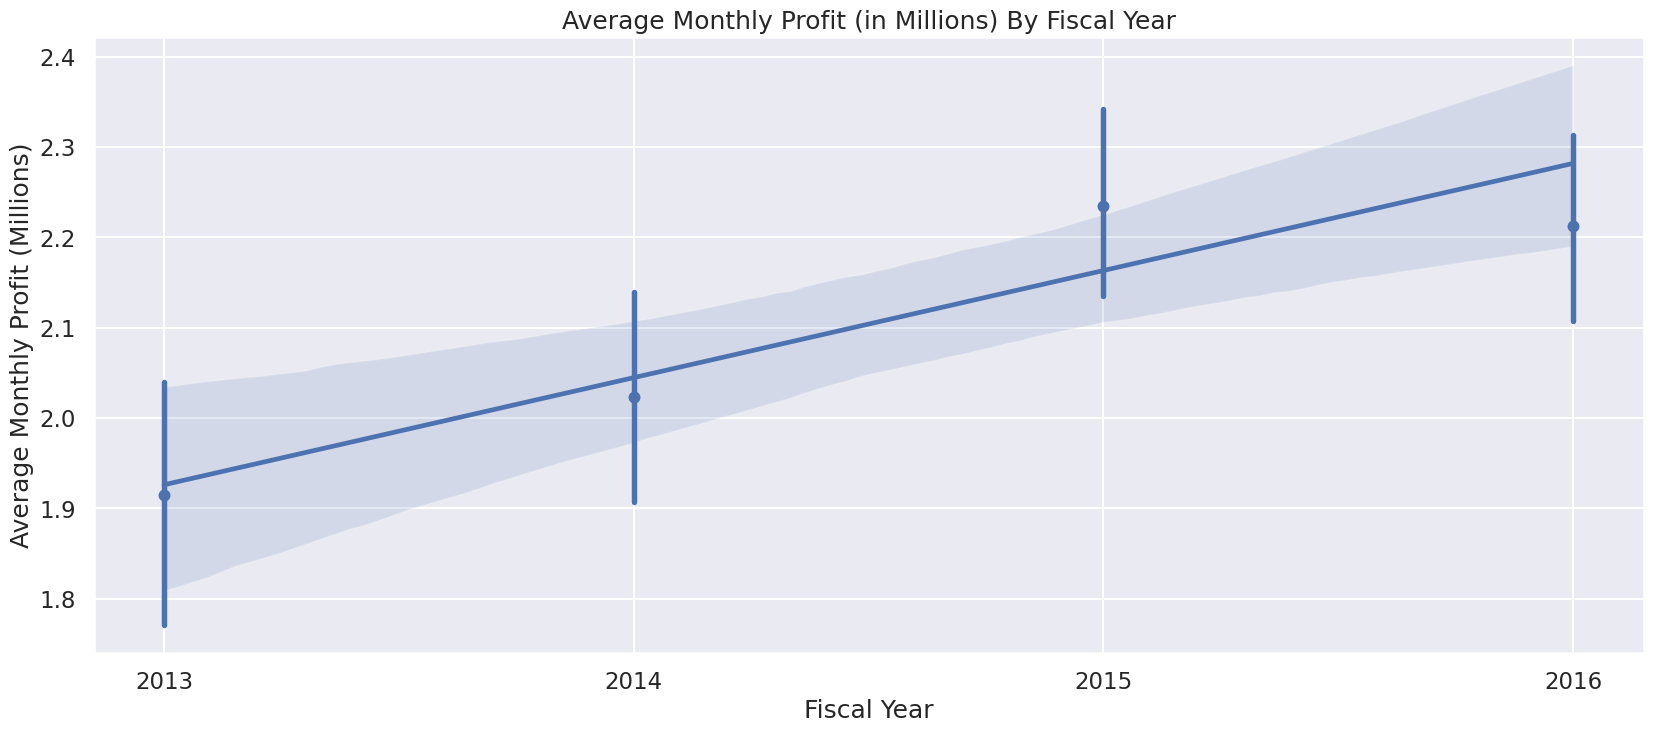

In [8]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.regplot(
    x="Fiscal Year",
    y="Profit (Millions)",
    data=profits_by_fiscal_month,
    x_estimator=np.mean,
    ax=ax,
)
plt.xticks(profits_by_fiscal_month["Fiscal Year"].unique())
plt.ylabel("Average Monthly Profit (Millions)")
plt.title("Average Monthly Profit (in Millions) By Fiscal Year");

### What is the Estimated Average Growth Rate in Profits?

#### Average Monthly Profits Per Year

In [71]:
x = profits_by_fiscal_month["Fiscal Year"]
y = profits_by_fiscal_month["Profit (Millions)"]

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Profit (Millions)   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     15.38
Date:                Thu, 05 Jan 2023   Prob (F-statistic):           0.000346
Time:                        14:24:35   Log-Likelihood:                 8.8282
No. Observations:                  41   AIC:                            -13.66
Df Residuals:                      39   BIC:                            -10.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -236.8241     60.916     -3.888      0.000    -360.039    -113.609
Fiscal Year     0.1186      0.030      3.922      0.000       0.057       0.180
==============================================================================
Omnibus:                        1.124   Durbin-Watson:                   0.917
Prob(Omnibus):                  0.570   Jarque-Bera (JB):                0.396
Skew:                          -0.154   Prob(JB):                        0.820
Kurtosis:                       3.371   Cond. No.                     3.93e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
print("Estimated Average Monthly Growth Rate:")
print(f"${(results.params[1]*1000).round(-1)}K (+- ${(results.bse[1]*1000).round(-1)}K) per year")
# print(f"${(results.params[1]*12).round(1)}M (+- {(results.bse[1]*1000*12).round(-2)}K) per year")

Estimated Average Monthly Growth Rate:
$120.0K (+- $30.0K) per year


In [63]:
future = np.arange(2017, 2027)
future = sm.add_constant(future)

monthly_profit_predictions = results.predict(future)

print("Predicted Average Monthly Profits:")
for i, monthly_profit in enumerate(monthly_profit_predictions):
    print(
        f"{int(future[i][1])}: ${monthly_profit.round(1)}M per month"
    )

Predicted Average Monthly Profits:
2017: $2.4M per month
2018: $2.5M per month
2019: $2.6M per month
2020: $2.8M per month
2021: $2.9M per month
2022: $3.0M per month
2023: $3.1M per month
2024: $3.2M per month
2025: $3.3M per month
2026: $3.5M per month


#### Average Daily Profits Per Month

In [55]:
profits_by_date = df.groupby(
    ["Date"]
    )[
        ["Profit", "Profit (Thousands)"]
    ].sum().reset_index().sort_values(["Date"])
    
profits_by_date["Month"] = profits_by_date["Date"].dt.to_period('M').astype(str)

profits_by_date["monthnum"] = datestr2num(profits_by_date["Month"])

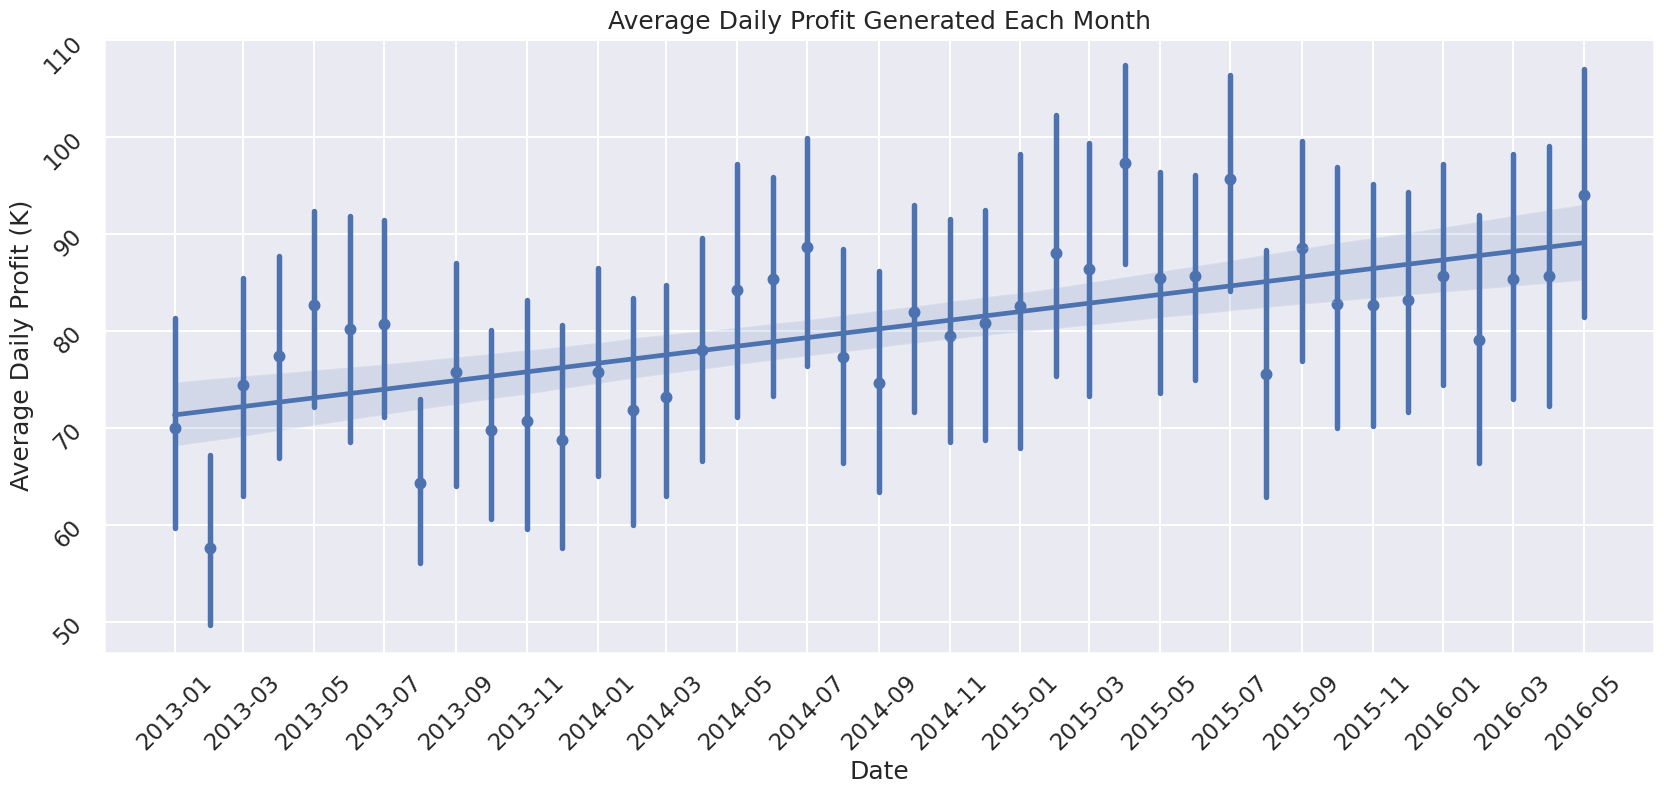

In [39]:
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return num2date(x).strftime('%Y-%m')

figure, ax = plt.subplots(
    figsize=(20,8)
)

ax.xaxis.set_major_formatter(fake_dates)
ax.tick_params(labelrotation=45)

sns.regplot(
    x="monthnum",
    y="Profit (Thousands)",
    data=profits_by_date,
    x_estimator=np.mean,
    order=1,
    ax=ax,
)

plt.xticks(profits_by_date["monthnum"].unique()[::2])
plt.xlabel("Date")
plt.ylabel("Average Daily Profit (K)")
plt.title("Average Daily Profit Generated Each Month");

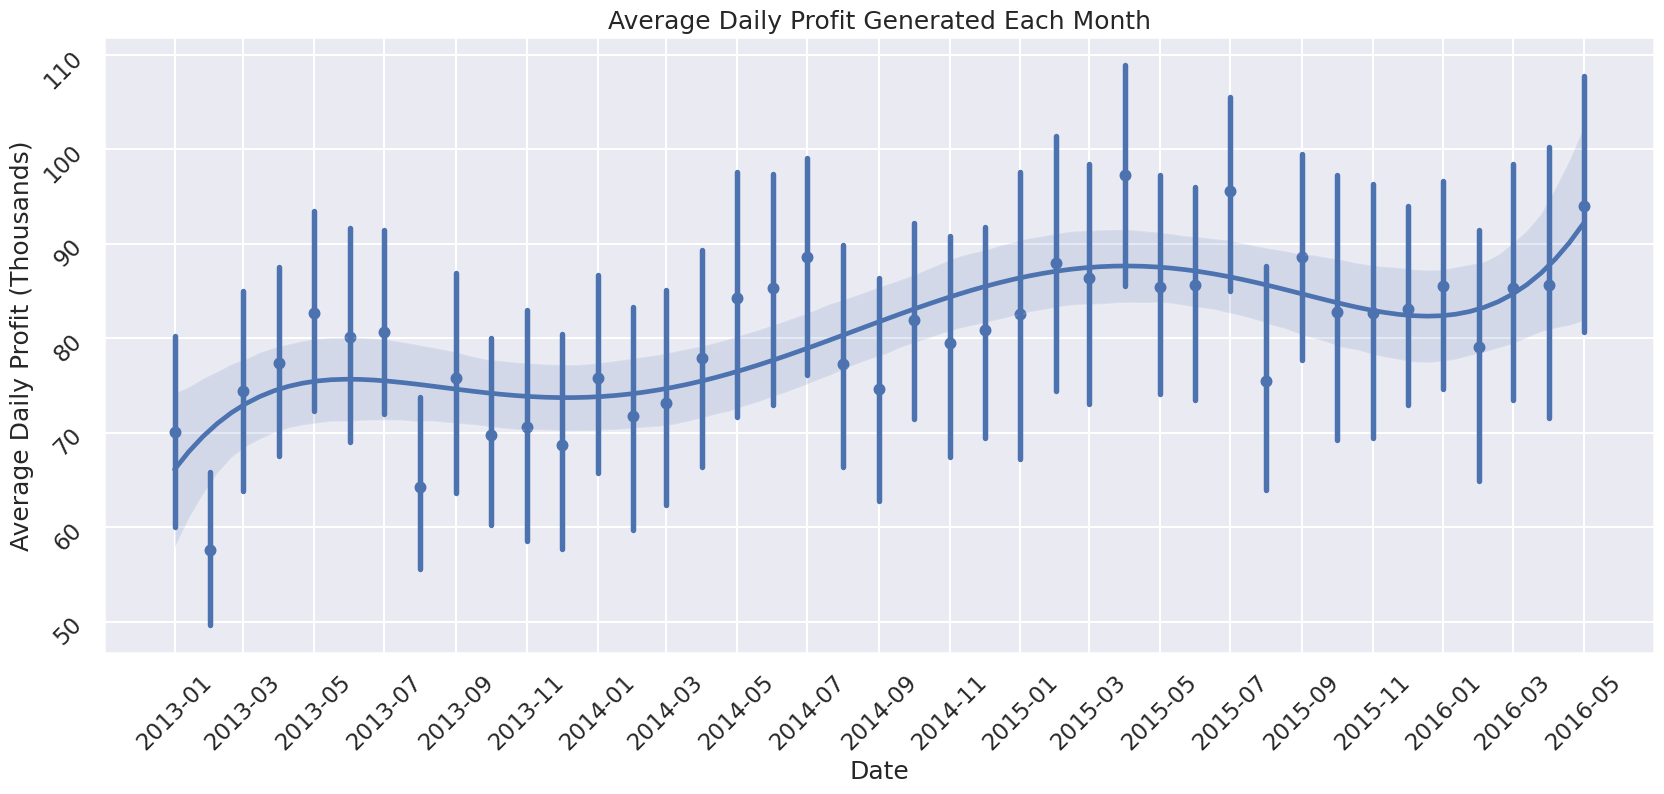

In [74]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

ax.xaxis.set_major_formatter(fake_dates)
ax.tick_params(labelrotation=45)

sns.regplot(
    x="monthnum",
    y="Profit (Thousands)",
    data=profits_by_date,
    x_estimator=np.mean,
    order=5,
    ax=ax,
)

plt.xticks(profits_by_date["monthnum"].unique()[::2])
plt.xlabel("Date")
plt.ylabel("Average Daily Profit (Thousands)")
plt.title("Average Daily Profit Generated Each Month");

In [78]:
x = profits_by_date["monthnum"]
y = profits_by_date["Profit"]

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     30.60
Date:                Thu, 05 Jan 2023   Prob (F-statistic):           3.99e-08
Time:                        14:36:59   Log-Likelihood:                -12572.
No. Observations:                1069   AIC:                         2.515e+04
Df Residuals:                    1067   BIC:                         2.516e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.579e+05    4.3e+04     -3.667      0.000   -2.42e+05   -7.34e+04
monthnum      14.5881      2.637      5.531      0.000       9.413      19.763
==============================================================================
Omnibus:                       87.672   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.746
Skew:                           0.087   Prob(JB):                     3.47e-07
Kurtosis:                       2.202   Cond. No.                     7.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
(profits_by_date["monthnum"] - profits_by_date["monthnum"].min()).unique()


array([   0.,   31.,   59.,   90.,  120.,  151.,  181.,  212.,  243.,
        273.,  304.,  334.,  365.,  396.,  424.,  455.,  485.,  516.,
        546.,  577.,  608.,  638.,  669.,  699.,  730.,  761.,  789.,
        820.,  850.,  881.,  911.,  942.,  973., 1003., 1034., 1064.,
       1095., 1126., 1155., 1186., 1216.])

In [79]:
print("Estimated Average Daily Growth Rate:")
print(f"${results.params[1].round(2)} (+- ${results.bse[1].round(2)}) per month")

Estimated Average Daily Growth Rate:
$14.59 (+- $2.64) per month


## What Are the Most Profitable Products?

### All Time Most Profitable

In [ ]:
total_profit_per_product = df.groupby("Stock Item")["Profit (Millions)"].sum()

top_products_all_time = total_profit_per_product.nlargest(25).reset_index()
bottom_products_all_time = total_profit_per_product.nsmallest(25).reset_index()

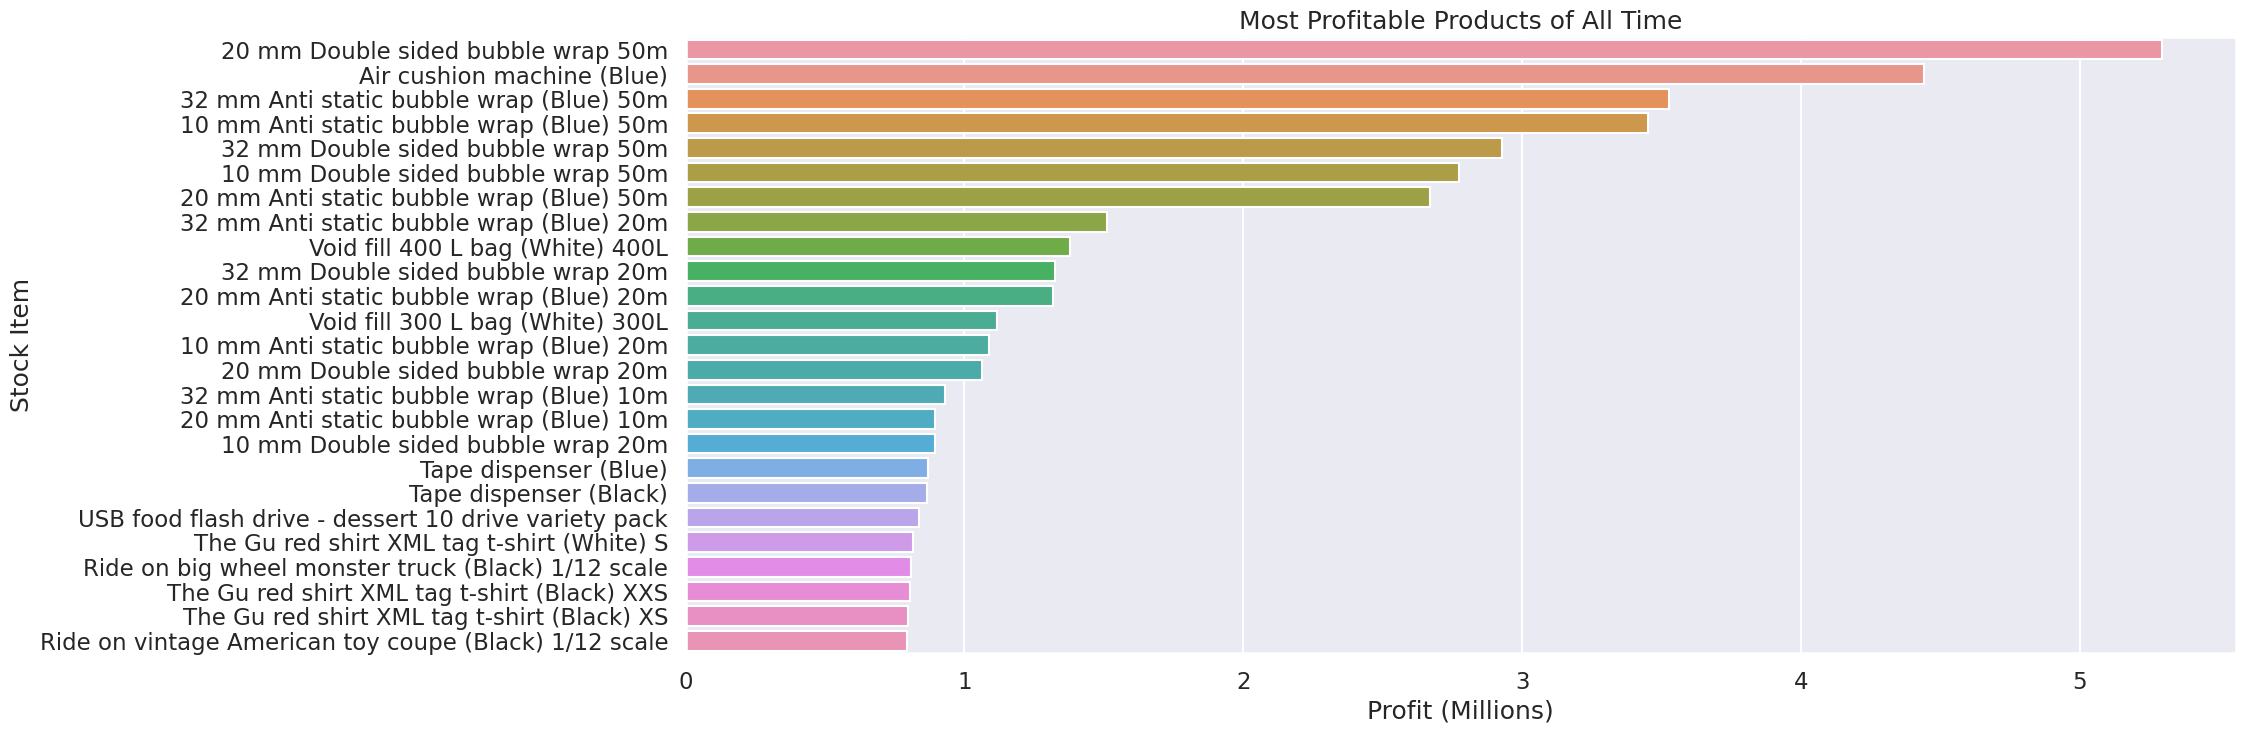

In [ ]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    y="Stock Item",
    x="Profit (Millions)",
    data=top_products_all_time,
    ax=ax,
)

plt.title("Most Profitable Products of All Time");

### All Time Least Profitable

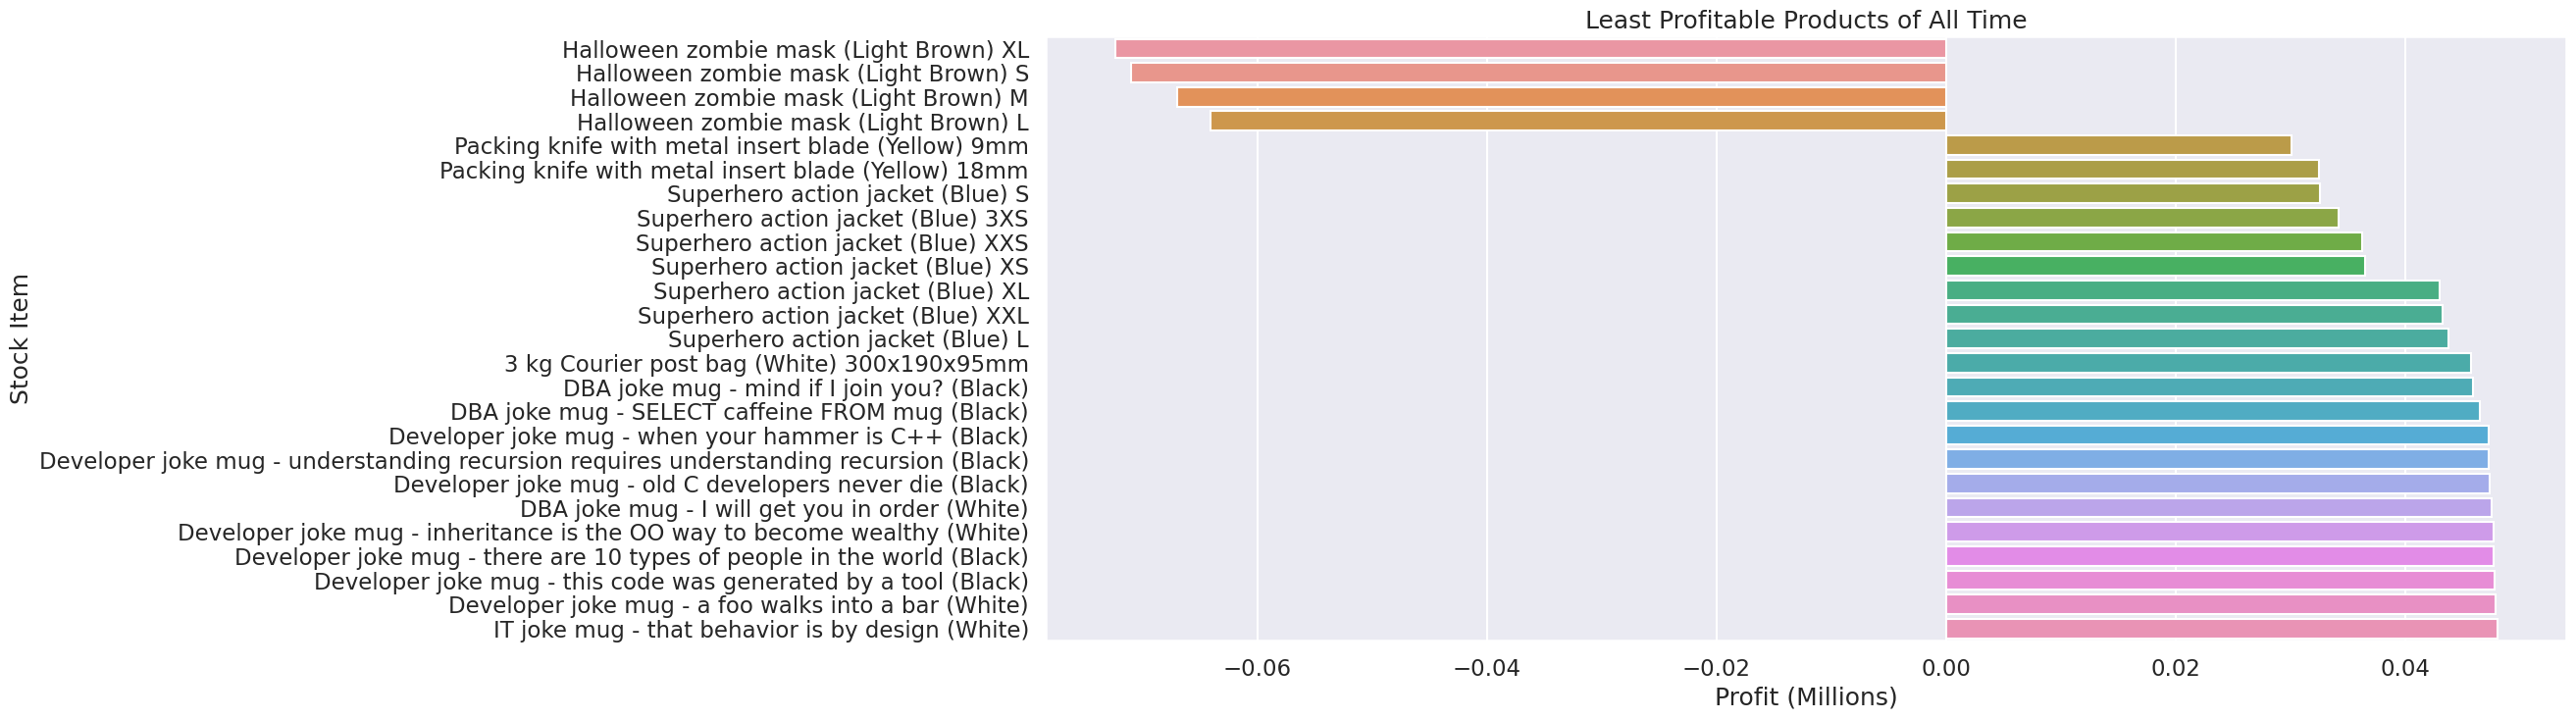

In [ ]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    y="Stock Item",
    x="Profit (Millions)",
    data=bottom_products_all_time,
    ax=ax,
)

plt.title("Least Profitable Products of All Time");